1. add all HO data together
2. add all lost df together
3. 

In [98]:
import os
import re
import ast
import copy
import json
import swifter
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas import Timestamp
from collections import namedtuple
from datetime import timedelta, datetime

from utils import *

Read previous data

In [99]:
# HO = namedtuple('HO', ['start', 'end', 'others', 'trans'], defaults=[None, None, '', ''])

# def ho_encoder(obj):
#     if isinstance(obj, datetime):
#         return obj.strftime('%Y-%m-%d %H:%M:%S.%f')  # Convert datetime to string
#     return obj


In [100]:
# concated_ordered_ho_path = "/Volumes/MOLLY256/MOXA/concated_data/Handover"
# concated_loss_file_path = "/Volumes/MOLLY256/MOXA/concated_data/PacketLoss"
# concated_file_path = ""

all_ordered_ho_datas = []
all_ho_dict = {'Conn_Rel': [], 'Conn_Req': [], 'LTE_HO': [], 'MN_HO': [], 'MN_HO_to_eNB': [], 'SN_setup': [], 'SN_Rel': [], 'SN_HO': [], 
               'RLF_II': [], 'RLF_III': [], 'SCG_RLF': []}

# with open(f"{concated_ordered_ho_path}/concated_HOs.json", 'r') as f:
#     all_ho_dict = json.load(f)
# # Convert Timestamp strings back to Timestamp objects
# for key, value in all_ho_dict.items():
#     all_ho_dict[key] = [HO(start=pd.to_datetime(ho[0], format='%Y-%m-%d %H:%M:%S.%f'), 
#                            end=pd.to_datetime(ho[1], format='%Y-%m-%d %H:%M:%S.%f') if ho[1] is not None else None, 
#                            others=ho[2],
#                            trans=ho[3]) for ho in value]


# all_ul_loss_df = pd.read_csv(f"{concated_loss_file_path}/concated_ul_loss.csv")
# all_dl_loss_df = pd.read_csv(f"{concated_loss_file_path}/concated_dl_loss.csv")

figure_path = "/Users/molly/Desktop"

event_dict = {'Conn_Rel': 1, 'Conn_Req': 2, 'LTE_HO': 3, 'MN_HO': 4, 'MN_HO_to_eNB': 5, 'SN_setup': 6, 'SN_Rel': 7, 'SN_HO': 8, 'stable': 0, 
              'RLF_II': 9, 'RLF_III': 10, 'SCG_RLF': 11, 'Add_Scell': 12}
colors_dict = {'Conn_Rel': '#ed5555', 'Conn_Req': '#78c4b1', 'LTE_HO': '#3ea357', 'MN_HO': '#e8803a', 
               'MN_HO_to_eNB': '#ad58c4', 'SN_setup': '#ddbfde', 'SN_Rel': '#a1543f', 'SN_HO': '#d4c68a', 'stable': '#878483',
               'RLF_II': '#59a2c2', 'RLF_III': '#6494c4', 'SCG_RLF': '#646fc4'}

In [101]:
### USER SETTINGS ###
database="/Volumes/mollyT7/MOXA"
# database = "/Volumes/MOLLY256/MOXA/"
# database = "/Users/molly/Desktop"

dates = [
    # "/Users/molly/Desktop/2024-01-26",
    # "2024-02-03",
    # "2024-02-17",
    "2024-03-13",
    # "2024-03-21",
]
devices = sorted([
    "sm00",
    "sm01",
])
exps = {
    # "QUIC-280sec": (6, ["#{:02d}".format(i + 1) for i in range(6)]),
    # "QUIC-300sec": (6, ["#{:02d}".format(i + 1) for i in range(6)]),
    # "QUIC-450sec": (6, ["#{:02d}".format(i + 1) for i in range(6)]),
    "QUIC-1M": (2, ["#{:02d}".format(i + 1) for i in range(2)]),
    # "QUIC-inf": (5, ["#{:02d}".format(i + 1) for i in range(5)]),
}

device_to_port = {"sm00": [4200, 4201, 5200, 5201], 
                  "sm01": [4202, 4203, 5202, 5203],
                  "sm02": [4204, 4205, 5204, 5205]}

### Get Handover Data

In [102]:
# # FUNCTIONS
def find_rrc_files(database, date, exp, device):
    rrc_files = []
    exp_rounds, exp_list = exps[exp]
    for exp_round in exp_list:
        folder_path = os.path.join(database, date, exp, device, exp_round, 'data')
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if "_rrc.csv" in file:
                    rrc_files.append(os.path.join(root, file))
    return rrc_files

In [103]:
new_rrc_files = []
# Iterate over dates, exps, and devices
for date in dates:
    for exp in exps:
        for device in devices:
            # Find "rrc" files for the current combination of date, exp, and device
            rrc_files = find_rrc_files(database, date, exp, device)
            # Extend the list of all "rrc" files
            new_rrc_files.extend(rrc_files)

In [104]:
# Read all "rrc" files
all_mappings = {'LTE_HO':[], 'NR_HO':[], 'SN_setup':[]}
rrc_time_pattern = r"(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})"
for file in new_rrc_files:
    # print(file)
    HOs = parse_mi_ho(file)
    for key in all_ho_dict.keys():
        all_ho_dict[key].extend(HOs[key])
    
    MRs = MeasureReport(file)
    MRs = correct_MR_with_HO(MRs, HOs)
    mappings = map_MR_HO(MRs, HOs)
    for key in all_mappings.keys():
        all_mappings[key].extend(mappings[key])
    ordered_HOs = print_trans(HOs, mappings=mappings)
    match = re.search(rrc_time_pattern, os.path.basename(file))
    if match:
        start_time = match.group(1)
        # Convert the timestamp string to a datetime object
        threshold_timestamp = datetime.strptime(start_time, '%Y-%m-%d_%H-%M-%S')
        # Filter entries based on the threshold timestamp
        filtered_entries = [entry for entry in ordered_HOs if entry[1].start > threshold_timestamp]
    
    all_ordered_ho_datas.extend(ordered_HOs)

2024-03-13 10:53:50.085172 | MN_HO | (44, 3050) -> (329, 3050) | 44 | eventA3 | {}
2024-03-13 10:53:55.524014 | SN_HO | (329, 3050) | 44 -> 329 | eventA3 | {'off': 6, 'hys': 1, 'ttt': 640}
2024-03-13 10:54:11.151938 | SN_HO | (329, 3050) | 329 -> 87 | eventA3 | {'off': 6, 'hys': 1, 'ttt': 640}
2024-03-13 10:54:11.228349 | MN_HO_to_eNB | (329, 3050) -> (87, 3050) | 87 -> O | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-03-13 10:54:11.542629 | SN_setup | (87, 3050) | O -> 87 | eventB1-NR-r15 | {'thr': '[-111&-110)', 'hys': 0, 'ttt': 100}
2024-03-13 10:54:27.172634 | MN_HO | (87, 3050) -> (287, 3050) | 87 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-03-13 10:54:44.656731 | MN_HO | (287, 3050) -> (279, 3050) | 87 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-03-13 10:54:46.362950 | MN_HO | (279, 3050) -> (287, 3050) | 87 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-03-13 10:54:49.815794 | MN_HO | (287, 3050) -> (329, 3050) | 87 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}


In [105]:
# for key, value in all_ho_dict.items():
#     all_ho_dict[key] = [ho._replace(start=str(ho.start), end=str(ho.end) if ho.end is not None else None) for ho in value]

# export HOs as a .json file
# with open(f"{concated_ordered_ho_path}/concated_HOs.json", 'w') as f:
#     json.dump(all_ho_dict, f, default=ho_encoder, indent=4)


### Get Packet Loss Data

In [106]:
def find_ul_file(database, date, exp, device):
    ul_files = []
    exp_rounds, exp_list = exps[exp]
    ports = device_to_port.get(device, [])
    for exp_round in exp_list:
        folder_path = os.path.join(database, date, exp, device, exp_round, 'data')
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if "processed_sent" in file:
                    # Extract the numbers from the file name
                    numbers = file.split("_")[3]
                    if str(ports[2]) in numbers or str(ports[0]) in numbers:
                        ul_files.append(os.path.join(root, file))
                        break  # Exit the inner loop once the port is found
    return ul_files

def find_dl_file(database, date, exp, device):
    dl_files = []
    exp_rounds, exp_list = exps[exp]
    ports = device_to_port.get(device, [])
    for exp_round in exp_list:
        folder_path = os.path.join(database, date, exp, device, exp_round, 'data')
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if "processed_sent" in file:
                    # Extract the numbers from the file name
                    numbers = file.split("_")[3]
                    if str(ports[3]) in numbers or str(ports[1]) in numbers:
                        dl_files.append(os.path.join(root, file))
                        break  # Exit the inner loop once the port is found
    return dl_files

def find_ul_loss_file(database, date, exp, device):
    ul_loss_files = []
    exp_rounds, exp_list = exps[exp]
    ports = device_to_port.get(device, [])
    for exp_round in exp_list:
        folder_path = os.path.join(database, date, exp, device, exp_round, 'data')
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if "ul_real_lost_pk" in file:
                    ul_loss_files.append(os.path.join(root, file))
                    break  # Exit the inner loop once the port is found
    return ul_loss_files

def find_dl_loss_file(database, date, exp, device):
    dl_loss_files = []
    exp_rounds, exp_list = exps[exp]
    ports = device_to_port.get(device, [])
    for exp_round in exp_list:
        folder_path = os.path.join(database, date, exp, device, exp_round, 'data')
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if "dl_real_lost_pk" in file:
                    dl_loss_files.append(os.path.join(root, file))
                    break  # Exit the inner loop once the port is found
    return dl_loss_files



In [107]:
all_ul_files = []
all_ul_pkl_files = []
# Iterate over dates, exps, and devices
for date in dates:
    for exp in exps:
        for device in devices:
            ul_pk_files = find_ul_file(database, date, exp, device)
            ul_pk_loss_files = find_ul_loss_file(database, date, exp, device)
            all_ul_files.extend(ul_pk_files)
            all_ul_pkl_files.extend(ul_pk_loss_files)

ul_dfs = []
ul_loss_dfs = []
# Iterate over each file path
for file_path in all_ul_files:
    ul_df = pd.read_csv(file_path, sep='@')
    ul_dfs.append(ul_df)
for file_path in all_ul_pkl_files:
    # Read CSV file into a DataFrame and append it to the list
    ul_loss_df = pd.read_csv(file_path)
    ul_loss_dfs.append(ul_loss_df)
# Concatenate all DataFrames into a single DataFrame
all_ul_df = pd.concat(ul_dfs, ignore_index=True)
all_ul_loss_df = pd.concat(ul_loss_dfs, ignore_index=True)

all_ul_real_loss_df = all_ul_loss_df[all_ul_loss_df['lost']==True]
all_ul_excl_df = all_ul_loss_df[all_ul_loss_df['excl']==True]


In [108]:
all_ul_pkl_files

['/Volumes/mollyT7/MOXA/2024-03-13/QUIC-1M/sm00/#01/data/ul_real_lost_pk.csv',
 '/Volumes/mollyT7/MOXA/2024-03-13/QUIC-1M/sm00/#02/data/ul_real_lost_pk.csv',
 '/Volumes/mollyT7/MOXA/2024-03-13/QUIC-1M/sm01/#01/data/ul_real_lost_pk.csv',
 '/Volumes/mollyT7/MOXA/2024-03-13/QUIC-1M/sm01/#02/data/ul_real_lost_pk.csv']

In [109]:
all_dl_files = []
all_dl_pkl_files = []
# Iterate over dates, exps, and devices
for date in dates:
    for exp in exps:
        for device in devices:
            dl_pk_files = find_dl_file(database, date, exp, device)
            dl_pk_loss_files = find_dl_loss_file(database, date, exp, device)
            all_dl_files.extend(dl_pk_files)
            all_dl_pkl_files.extend(dl_pk_loss_files)

dl_dfs = []
dl_loss_dfs = []
# Iterate over each file path
for file_path in all_dl_files:
    dl_df = pd.read_csv(file_path, sep='@')
    dl_dfs.append(dl_df)
for file_path in all_dl_pkl_files:
    # Read CSV file into a DataFrame and append it to the list
    dl_loss_df = pd.read_csv(file_path)
    dl_loss_dfs.append(dl_loss_df)
# Concatenate all DataFrames into a single DataFrame
all_dl_df = pd.concat(dl_dfs, ignore_index=True)
all_dl_loss_df = pd.concat(dl_loss_dfs, ignore_index=True)

all_dl_real_loss_df = all_dl_loss_df[all_dl_loss_df['lost']==True]
all_dl_excl_df = all_dl_loss_df[all_dl_loss_df['excl']==True]

In [110]:
print(len(all_ul_real_loss_df), len(all_dl_real_loss_df))
print(len(all_ul_loss_df), len(all_dl_loss_df))

152 697
957 729


In [111]:
# all_ul_loss_df.to_csv(f"{concated_loss_file_path}/concated_ul_loss.csv", index=False)
# all_dl_loss_df.to_csv(f"{concated_loss_file_path}/concated_dl_loss.csv", index=False)

### Handover Interval

In [112]:
all_ul_loss_df['ho_type'] = 0
all_dl_loss_df['ho_type'] = 0
all_ul_real_loss_df['ho_type'] = 0
all_dl_real_loss_df['ho_type'] = 0

/var/folders/ll/z00qrhv13397cv4_52zrrb200000gn/T/ipykernel_5703/3571754206.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_ul_real_loss_df['ho_type'] = 0
/var/folders/ll/z00qrhv13397cv4_52zrrb200000gn/T/ipykernel_5703/3571754206.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dl_real_loss_df['ho_type'] = 0


In [113]:
def count_records_within_1_second(all_pk_df, loss_latency_df, D, event_dict):
    # Convert timestamp columns to datetime objects
    all_pk_df['timestamp'] = pd.to_datetime(all_pk_df['timestamp'])
    loss_latency_df['timestamp'] = pd.to_datetime(loss_latency_df['timestamp'])

    # Initialize a dictionary to store the counts for each event type
    event_counts = {}
    event_loss_counts = {}
    # event = {'Event Type': [], 'HO Object': [], 'before': [], 'before_event': [], 'during':[], 'during_event': [], 'after': [], 'after_event': []}
    events_list = []


    # Loop through each event type in D
    for event_type, ho_objects in D.items():
        if event_type == "Add_SCell":
            continue
        event_counts[event_type] = {'before': [], 'during':[], 'after': []}
        event_loss_counts[event_type] = {'before': [], 'during':[], 'after': []}

        # Loop through each HO object in the current event type
        for ho in ho_objects:
            event = {'loss_before': [], 'loss_before_event': [], 'loss_during':[], 'loss_during_event': [], 'loss_after': [], 'loss_after_event': [], 
                     'sent_before': [], 'sent_during': [], 'sent_after': []}
            if ho.end is not None:
                start = pd.to_datetime(ho.start)
                end = pd.to_datetime(ho.end)
                sec_before_start = start - timedelta(seconds=1)
                sec_after_end = end + timedelta(seconds=1)
            else:
                # continue
                start = pd.to_datetime(ho.start)
                end = pd.to_datetime(ho.start)
                sec_before_start = start - timedelta(seconds=1)
                sec_after_end = start + timedelta(seconds=1)
            # print(start_time, ho.start, loss_latency_df['timestamp'])

            # Filter and display the records in loss_latency_df within the specified time range
            relevant_loss_before = loss_latency_df[(start > loss_latency_df['timestamp']) & (loss_latency_df['timestamp'] >= sec_before_start)]
            relevant_loss_after = loss_latency_df[(end < loss_latency_df['timestamp']) & (loss_latency_df['timestamp'] <= sec_after_end)]
            relevant_loss_during = loss_latency_df[(start <= loss_latency_df['timestamp']) & (loss_latency_df['timestamp'] <= end)]
            relevant_sent_before = all_pk_df[(start > all_pk_df['timestamp']) & (all_pk_df['timestamp'] >= sec_before_start)]
            relevant_sent_after = all_pk_df[(end < all_pk_df['timestamp']) & (all_pk_df['timestamp'] <= sec_after_end)]
            relevant_sent_during = all_pk_df[(start <= all_pk_df['timestamp']) & (all_pk_df['timestamp'] <= end)]

            for records_df in [relevant_loss_before, relevant_loss_during, relevant_loss_after]:
                records_df.loc[records_df['ho_type'] == 0, 'ho_type'] = event_dict[event_type]

            loss_latency_df.loc[relevant_loss_before.index] = relevant_loss_before
            loss_latency_df.loc[relevant_loss_during.index] = relevant_loss_during
            loss_latency_df.loc[relevant_loss_after.index] = relevant_loss_after

            event_loss_counts[event_type]['before'].append(len(relevant_loss_before))
            event_loss_counts[event_type]['after'].append(len(relevant_loss_after))
            event_loss_counts[event_type]['during'].append(len(relevant_loss_during))
            event_counts[event_type]['before'].append(len(relevant_sent_before))
            event_counts[event_type]['after'].append(len(relevant_sent_after))
            event_counts[event_type]['during'].append(len(relevant_sent_during))

            event['Event Type'] = f"{event_type}"
            event['HO Object'] = f"{ho}"
            event['before'] = len(relevant_loss_before)
            event['before_event'] = relevant_loss_before
            event['during'] = len(relevant_loss_during)
            event['during_event'] = relevant_loss_during
            event['after'] = len(relevant_loss_after)
            event['after_event'] = relevant_loss_after
            event['sent_before'] = len(relevant_sent_before)
            event['sent_during'] = len(relevant_sent_during)
            event['sent_after'] = len(relevant_sent_after)

            events_list.append(event)

    return events_list, event_counts, event_loss_counts, loss_latency_df

def calculate_event_sums_lists(event_counts):
    success_sum_before = {}
    success_sum_during = {}
    success_sum_after = {}
    failure_sum_before = {}
    failure_sum_after = {}
    # Initialize lists to store the sums of before, during, and after counts
    success_sum_before_list = []
    success_sum_during_list = []
    success_sum_after_list = []
    failure_sum_before_list = []
    failure_sum_after_list = []

    # Loop through each event type
    for event_type, counts in event_counts.items():
        # Initialize sums for this event type
        if (event_type == 'RLF_II') or (event_type == 'RLF_III') or (event_type == 'SCG_RLF'):
            failure_sum_before[event_type] = sum(counts['before'])
            failure_sum_after[event_type] = sum(counts['after'])
            failure_sum_before_list.append(sum(counts['before']))
            failure_sum_after_list.append(sum(counts['after']))
            
        elif (event_type != 'Add_SCell'):
            success_sum_before[event_type] = sum(counts['before'])
            success_sum_during[event_type] = sum(counts['during'])
            success_sum_after[event_type] = sum(counts['after'])
            success_sum_before_list.append(sum(counts['before']))
            success_sum_during_list.append(sum(counts['during']))
            success_sum_after_list.append(sum(counts['after']))

    return success_sum_before_list, success_sum_during_list, success_sum_after_list, failure_sum_before_list, failure_sum_after_list, success_sum_before, success_sum_during, success_sum_after, failure_sum_before, failure_sum_after

def plot_event_sums(ul_dl, success_sum_before_list, success_sum_during_list, success_sum_after_list,
                    failure_sum_before_list, failure_sum_after_list):
    x = ['Conn_Rel',
         'Conn_Req',  # Setup
         'LTE_HO',  # LTE -> newLTE
         'MN_HO',  # LTE + NR -> newLTE + NR
         'MN_HO_to_eNB',  # LTE + NR -> newLTE
         'SN_setup',  # LTE -> LTE + NR => NR setup
         'SN_Rel',  # LTE + NR -> LTE
         'SN_HO',  # LTE + NR -> LTE + newNR
         ]

    w = 0.2

    # Create an array of indices for x-axis positioning
    indices = np.arange(len(x))

    # Create a wider figure (e.g., width=10 inches, height=6 inches)
    # plt.figure(figsize=(12, 5))
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))  # 2 rows, 1 column of subplots
    ax1.bar(indices, success_sum_before_list, color='#edc56d', width=0.15, align='edge', label='before event')
    ax1.bar(indices + 1.1 * w, success_sum_during_list, color='#6db6ed', width=0.15, label='during event')
    ax1.bar(indices + 1.8 * w, success_sum_after_list, color='#e4a2f2', width=0.15, label='after event')

    # Set custom x-axis labels
    ax1.set_xticks(indices + w)
    ax1.set_xticklabels(x)
    ax1.legend()

    x2 = ['RLF_II',  # fail but reestablishment success
          'RLF_III',  # fail but reestablishment reject
          'SCG_RLF'
          ]

    # Create an array of indices for x-axis positioning
    indices2 = np.arange(len(x2))

    ax2.bar(indices2, failure_sum_before_list, color='#edc56d', width=0.15, align='edge', label='before event')
    ax2.bar(indices2 + 1.6 * w, failure_sum_after_list, color='#e4a2f2', width=0.15, label='after event')

    # Set custom x-axis labels
    ax2.set_xticks(indices2 + 1 * w)
    ax2.set_xticklabels(x2)
    ax2.legend()

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.savefig(f"{figure_path}/ho_events_{ul_dl}.png")
    plt.show()

def LossProportion(data, ul_dl):

    filtered_data = {key: value for key, value in data.items() if key != 'stable' and value != 0}
    labels = [key for key, value in filtered_data.items() if value != 0]
    sizes = [value for value in filtered_data.values() if value != 0]
    colors = [colors_dict[key] for key in labels]

    fig, ax = plt.subplots()
    ax.pie(sizes, autopct='%1.1f%%', startangle=90, colors=colors)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title('Loss Proportion')
    plt.tight_layout(rect=[0, 0, 0.7, 1])
    plt.legend(labels, title="Event Types", loc="center left", bbox_to_anchor=(1, 0.5))

    plt.savefig(f"{figure_path}/pkl_proportion_{ul_dl}.png")
    plt.show()

    # Calculate the sum of values excluding 'stable'
    total_unstable = sum(value for key, value in data.items() if key != 'stable')

    plt.figure(figsize=(5, 5))
    plt.pie([total_unstable, data['stable']], labels=['Unstable', 'Stable'], autopct='%1.1f%%', startangle=90, colors=['#bea6ed', '#99969e'])
    plt.axis('equal')
    plt.title('Stable vs Unstable Proportion')

    # Save/show the plot for stable vs unstable proportion
    plt.tight_layout()
    plt.savefig(f"{figure_path}/brief_proportion_{ul_dl}.png")
    plt.show()

# concat proportion of packet loss in stable or unstable under ul & dl 
def UlDlStableProportion(ul_loss_df, dl_loss_df):
    # Calculate the sum of values excluding 'stable' for ul_loss_df
    ul_total_unstable = sum(value for key, value in ul_loss_df.items() if key != 'stable')
    ul_stable_value = ul_loss_df.get('stable', 0)

    # Calculate the sum of values excluding 'stable' for dl_loss_df
    dl_total_unstable = sum(value for key, value in dl_loss_df.items() if key != 'stable')
    dl_stable_value = dl_loss_df.get('stable', 0)

    plt.figure(figsize=(8, 4))

    # Plot ul_loss_df
    plt.subplot(1, 2, 1)
    plt.pie([ul_total_unstable, ul_stable_value], autopct='%1.1f%%', startangle=90, colors=['#bea6ed', '#99969e'])
    plt.axis('equal')
    # plt.title('UL Stable vs Unstable Proportion')

    # Plot dl_loss_df
    plt.subplot(1, 2, 2)
    plt.pie([dl_total_unstable, dl_stable_value], autopct='%1.1f%%', startangle=90, colors=['#bea6ed', '#99969e'])
    plt.axis('equal')
    # plt.title('DL Stable vs Unstable Proportion')

    # Add single figure title
    plt.suptitle('Stable vs Unstable Proportion', fontsize=16)

    # Add legend without labels
    plt.legend(['Unstable', 'Stable'], loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    # Save/show the plot for stable vs unstable proportion
    plt.tight_layout()
    plt.savefig(f"{figure_path}/brief_proportion_ul_dl.png")
    plt.show()

In [114]:
event_list_ul, event_counts_ul, event_loss_counts_ul, all_ul_loss_df = count_records_within_1_second(all_ul_df, all_ul_loss_df, all_ho_dict, event_dict)
event_list_dl, event_counts_dl, event_loss_counts_dl, all_dl_loss_df = count_records_within_1_second(all_dl_df, all_dl_loss_df, all_ho_dict, event_dict)

In [115]:
event_list_ul_real, event_counts_ul_real, event_loss_counts_ul_real, all_ul_real_loss_df = count_records_within_1_second(all_ul_df, all_ul_real_loss_df, all_ho_dict, event_dict)
event_list_dl_real, event_counts_dl_real, event_loss_counts_dl_real, all_dl_real_loss_df = count_records_within_1_second(all_dl_df, all_dl_real_loss_df, all_ho_dict, event_dict)

/var/folders/ll/z00qrhv13397cv4_52zrrb200000gn/T/ipykernel_5703/3819120290.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_latency_df['timestamp'] = pd.to_datetime(loss_latency_df['timestamp'])
/var/folders/ll/z00qrhv13397cv4_52zrrb200000gn/T/ipykernel_5703/3819120290.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_latency_df['timestamp'] = pd.to_datetime(loss_latency_df['timestamp'])


In [116]:
lost_count_ul = {}
pk_loss_rate_ul = {}
for event_type, counts in event_counts_ul.items():
    loss_count = sum(event_loss_counts_ul[event_type]['before']) + sum(event_loss_counts_ul[event_type]['during']) +sum(event_loss_counts_ul[event_type]['after'])
    sent_count = sum(counts['before']) +  sum(counts['during']) + sum(counts['after'])
    lost_count_ul[event_type] = loss_count
    pk_loss_rate_ul[event_type] = loss_count / sent_count if sent_count != 0 else 0
    print(event_type, loss_count, sent_count, pk_loss_rate_ul[event_type])

Conn_Rel 0 0 0
Conn_Req 0 522 0.0
LTE_HO 0 507 0.0
MN_HO 329 61585 0.005342209953722497
MN_HO_to_eNB 52 5333 0.009750609413088317
SN_setup 115 10957 0.010495573605914028
SN_Rel 0 0 0
SN_HO 425 60785 0.006991856543555153
RLF_II 57 5227 0.010904916778266693
RLF_III 0 557 0.0
SCG_RLF 0 0 0


In [117]:
real_lost_count_ul = {}
real_pk_loss_rate_ul = {}
for event_type, counts in event_counts_ul_real.items():
    loss_count = sum(event_loss_counts_ul_real[event_type]['before']) + sum(event_loss_counts_ul_real[event_type]['during']) +sum(event_loss_counts_ul_real[event_type]['after'])
    sent_count = sum(counts['before']) +  sum(counts['during']) + sum(counts['after'])
    real_lost_count_ul[event_type] = loss_count
    real_pk_loss_rate_ul[event_type] = loss_count / sent_count if sent_count != 0 else 0
    print(event_type, loss_count, sent_count, real_pk_loss_rate_ul[event_type])

Conn_Rel 0 0 0
Conn_Req 0 522 0.0
LTE_HO 0 507 0.0
MN_HO 85 61585 0.001380206219046846
MN_HO_to_eNB 26 5333 0.004875304706544159
SN_setup 42 10957 0.003833166012594688
SN_Rel 0 0 0
SN_HO 100 60785 0.0016451427161306242
RLF_II 19 5227 0.003634972259422231
RLF_III 0 557 0.0
SCG_RLF 0 0 0


In [118]:
lost_count_dl = {}
pk_loss_rate_dl = {}
for event_type, counts in event_counts_dl.items():
    loss_count = sum(event_loss_counts_dl[event_type]['before']) + sum(event_loss_counts_dl[event_type]['during']) +sum(event_loss_counts_dl[event_type]['after'])
    sent_count = sum(counts['before']) +  sum(counts['during']) + sum(counts['after'])
    lost_count_dl[event_type] = loss_count
    pk_loss_rate_dl[event_type] = loss_count / sent_count if sent_count != 0 else 0
    print(event_type, loss_count, sent_count, pk_loss_rate_dl[event_type])

Conn_Rel 0 0 0
Conn_Req 0 522 0.0
LTE_HO 0 507 0.0
MN_HO 418 61380 0.006810035842293907
MN_HO_to_eNB 50 5345 0.009354536950420954
SN_setup 167 10790 0.015477293790546803
SN_Rel 0 0 0
SN_HO 349 60463 0.005772125101301623
RLF_II 110 4857 0.022647724933086266
RLF_III 0 557 0.0
SCG_RLF 0 0 0


In [119]:
real_lost_count_dl = {}
real_pk_loss_rate_dl = {}
for event_type, counts in event_counts_dl.items():
    loss_count = sum(event_loss_counts_dl_real[event_type]['before']) + sum(event_loss_counts_dl_real[event_type]['during']) +sum(event_loss_counts_dl_real[event_type]['after'])
    sent_count = sum(counts['before']) +  sum(counts['during']) + sum(counts['after'])
    real_lost_count_dl[event_type] = loss_count
    real_pk_loss_rate_dl[event_type] = loss_count / sent_count if sent_count != 0 else 0
    print(event_type, loss_count, sent_count, real_pk_loss_rate_dl[event_type])

Conn_Rel 0 0 0
Conn_Req 0 522 0.0
LTE_HO 0 507 0.0
MN_HO 391 61380 0.0063701531443466925
MN_HO_to_eNB 46 5345 0.008606173994387277
SN_setup 163 10790 0.015106580166821131
SN_Rel 0 0 0
SN_HO 325 60463 0.0053751881315846056
RLF_II 110 4857 0.022647724933086266
RLF_III 0 557 0.0
SCG_RLF 0 0 0


In [120]:
print(lost_count_ul)
print(lost_count_dl)
print(pk_loss_rate_ul)
print(pk_loss_rate_dl)

{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 0, 'MN_HO': 329, 'MN_HO_to_eNB': 52, 'SN_setup': 115, 'SN_Rel': 0, 'SN_HO': 425, 'RLF_II': 57, 'RLF_III': 0, 'SCG_RLF': 0}
{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 0, 'MN_HO': 418, 'MN_HO_to_eNB': 50, 'SN_setup': 167, 'SN_Rel': 0, 'SN_HO': 349, 'RLF_II': 110, 'RLF_III': 0, 'SCG_RLF': 0}
{'Conn_Rel': 0, 'Conn_Req': 0.0, 'LTE_HO': 0.0, 'MN_HO': 0.005342209953722497, 'MN_HO_to_eNB': 0.009750609413088317, 'SN_setup': 0.010495573605914028, 'SN_Rel': 0, 'SN_HO': 0.006991856543555153, 'RLF_II': 0.010904916778266693, 'RLF_III': 0.0, 'SCG_RLF': 0}
{'Conn_Rel': 0, 'Conn_Req': 0.0, 'LTE_HO': 0.0, 'MN_HO': 0.006810035842293907, 'MN_HO_to_eNB': 0.009354536950420954, 'SN_setup': 0.015477293790546803, 'SN_Rel': 0, 'SN_HO': 0.005772125101301623, 'RLF_II': 0.022647724933086266, 'RLF_III': 0.0, 'SCG_RLF': 0}


In [121]:
print(real_lost_count_ul)
print(real_lost_count_dl)
print(real_pk_loss_rate_ul)
print(real_pk_loss_rate_dl)

{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 0, 'MN_HO': 85, 'MN_HO_to_eNB': 26, 'SN_setup': 42, 'SN_Rel': 0, 'SN_HO': 100, 'RLF_II': 19, 'RLF_III': 0, 'SCG_RLF': 0}
{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 0, 'MN_HO': 391, 'MN_HO_to_eNB': 46, 'SN_setup': 163, 'SN_Rel': 0, 'SN_HO': 325, 'RLF_II': 110, 'RLF_III': 0, 'SCG_RLF': 0}
{'Conn_Rel': 0, 'Conn_Req': 0.0, 'LTE_HO': 0.0, 'MN_HO': 0.001380206219046846, 'MN_HO_to_eNB': 0.004875304706544159, 'SN_setup': 0.003833166012594688, 'SN_Rel': 0, 'SN_HO': 0.0016451427161306242, 'RLF_II': 0.003634972259422231, 'RLF_III': 0.0, 'SCG_RLF': 0}
{'Conn_Rel': 0, 'Conn_Req': 0.0, 'LTE_HO': 0.0, 'MN_HO': 0.0063701531443466925, 'MN_HO_to_eNB': 0.008606173994387277, 'SN_setup': 0.015106580166821131, 'SN_Rel': 0, 'SN_HO': 0.0053751881315846056, 'RLF_II': 0.022647724933086266, 'RLF_III': 0.0, 'SCG_RLF': 0}


Loss Proportion

In [122]:
# Calculated by "REAL" lost
success_ho_lost_sum_ul = len(all_ul_real_loss_df[(all_ul_real_loss_df['ho_type'] >= 1) & (all_ul_real_loss_df['ho_type'] <= 8)])
failure_ho_lost_sum_ul = len(all_ul_real_loss_df[(all_ul_real_loss_df['ho_type'] >= 9) & (all_ul_real_loss_df['ho_type'] <= 11)])
ho_lost_sum_ul = success_ho_lost_sum_ul + failure_ho_lost_sum_ul
ho_lost_ratio_ul = -1 if len(all_ul_real_loss_df) == 0 else ho_lost_sum_ul / len(all_ul_real_loss_df)

success_ho_lost_sum_dl = len(all_dl_real_loss_df[(all_dl_real_loss_df['ho_type'] >= 1) & (all_dl_real_loss_df['ho_type'] <= 8)])
failure_ho_lost_sum_dl = len(all_dl_real_loss_df[(all_dl_real_loss_df['ho_type'] >= 9) & (all_dl_real_loss_df['ho_type'] <= 11)])
ho_lost_sum_dl = success_ho_lost_sum_dl + failure_ho_lost_sum_dl
ho_lost_ratio_dl = -1 if len(all_dl_real_loss_df) == 0 else ho_lost_sum_dl / len(all_dl_real_loss_df)

print(ho_lost_ratio_ul, ho_lost_ratio_dl)

0.868421052631579 0.7101865136298422


In [123]:
all_pkl_sum_ul = {}
success_pkl_sum_ul = {}
failure_pkl_sum_ul = {}

for event_type, ho_type in event_dict.items():
    # Calculate the sum for each event type
    if ho_type in range(1, 9):
        success_pkl_sum_ul[event_type] = len(all_ul_loss_df[all_ul_loss_df['ho_type'] == ho_type])
    if ho_type in range(9, 12):
        failure_pkl_sum_ul[event_type] = len(all_ul_loss_df[all_ul_loss_df['ho_type'] == ho_type])

all_pkl_sum_ul = {**success_pkl_sum_ul, **failure_pkl_sum_ul}
all_pkl_sum_ul['stable'] = len(all_ul_loss_df[all_ul_loss_df['ho_type'] == 0])

print(success_pkl_sum_ul)
print(failure_pkl_sum_ul)

{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 0, 'MN_HO': 255, 'MN_HO_to_eNB': 40, 'SN_setup': 56, 'SN_Rel': 0, 'SN_HO': 199}
{'RLF_II': 7, 'RLF_III': 0, 'SCG_RLF': 0}


In [124]:
all_pkl_sum_dl = {}
success_pkl_sum_dl = {}
failure_pkl_sum_dl = {}

for event_type, ho_type in event_dict.items():
    # Calculate the sum for each event type
    if ho_type in range(1, 9):
        success_pkl_sum_dl[event_type] = len(all_dl_loss_df[all_dl_loss_df['ho_type'] == ho_type])
    if ho_type in range(9, 12):
        failure_pkl_sum_dl[event_type] = len(all_dl_loss_df[all_dl_loss_df['ho_type'] == ho_type])

all_pkl_sum_dl = {**success_pkl_sum_dl, **failure_pkl_sum_dl}
all_pkl_sum_dl['stable'] = len(all_dl_loss_df[all_dl_loss_df['ho_type'] == 0])

print(success_pkl_sum_dl)
print(failure_pkl_sum_dl)

{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 0, 'MN_HO': 317, 'MN_HO_to_eNB': 15, 'SN_setup': 90, 'SN_Rel': 0, 'SN_HO': 98}
{'RLF_II': 0, 'RLF_III': 0, 'SCG_RLF': 0}


In [125]:
all_real_pkl_sum_ul = {}
success_real_pkl_sum_ul = {}
failure_real_pkl_sum_ul = {}

for event_type, ho_type in event_dict.items():
    # Calculate the sum for each event type
    if ho_type in range(1, 9):
        success_real_pkl_sum_ul[event_type] = len(all_ul_real_loss_df[all_ul_real_loss_df['ho_type'] == ho_type])
    if ho_type in range(9, 12):
        failure_real_pkl_sum_ul[event_type] = len(all_ul_real_loss_df[all_ul_real_loss_df['ho_type'] == ho_type])

all_real_pkl_sum_ul = {**success_real_pkl_sum_ul, **failure_real_pkl_sum_ul}
all_real_pkl_sum_ul['stable'] = len(all_ul_real_loss_df[all_ul_real_loss_df['ho_type'] == 0])

print(len(all_ul_real_loss_df), success_ho_lost_sum_ul, failure_ho_lost_sum_ul)
print(success_real_pkl_sum_ul)
print(failure_real_pkl_sum_ul)

152 132 0
{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 0, 'MN_HO': 68, 'MN_HO_to_eNB': 24, 'SN_setup': 16, 'SN_Rel': 0, 'SN_HO': 24}
{'RLF_II': 0, 'RLF_III': 0, 'SCG_RLF': 0}


In [126]:
all_real_pkl_sum_dl = {}
success_real_pkl_sum_dl = {}
failure_real_pkl_sum_dl = {}

for event_type, ho_type in event_dict.items():
    # Calculate the sum for each event type
    if ho_type in range(1, 9):
        success_real_pkl_sum_dl[event_type] = len(all_dl_real_loss_df[all_dl_real_loss_df['ho_type'] == ho_type])
    if ho_type in range(9, 12):
        failure_real_pkl_sum_dl[event_type] = len(all_dl_real_loss_df[all_dl_real_loss_df['ho_type'] == ho_type])

all_real_pkl_sum_dl = {**success_real_pkl_sum_dl, **failure_real_pkl_sum_dl}
all_real_pkl_sum_dl['stable'] = len(all_dl_real_loss_df[all_dl_real_loss_df['ho_type'] == 0])

print(success_real_pkl_sum_dl)
print(failure_real_pkl_sum_dl)

{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 0, 'MN_HO': 295, 'MN_HO_to_eNB': 14, 'SN_setup': 90, 'SN_Rel': 0, 'SN_HO': 96}
{'RLF_II': 0, 'RLF_III': 0, 'SCG_RLF': 0}


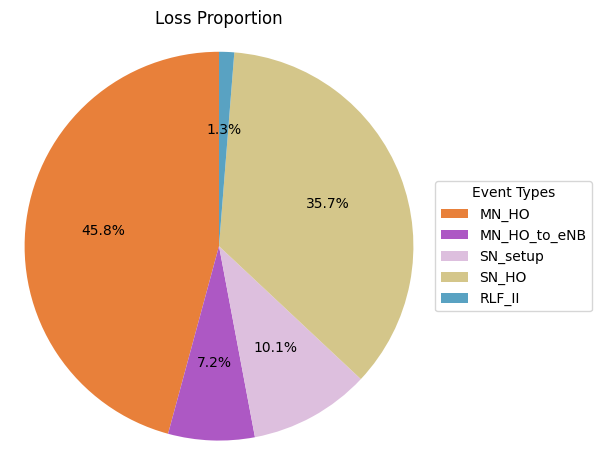

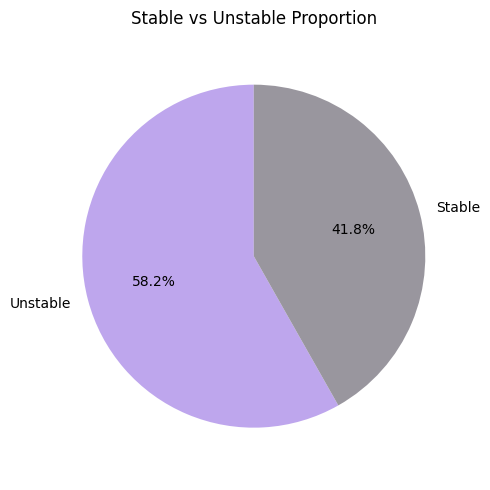

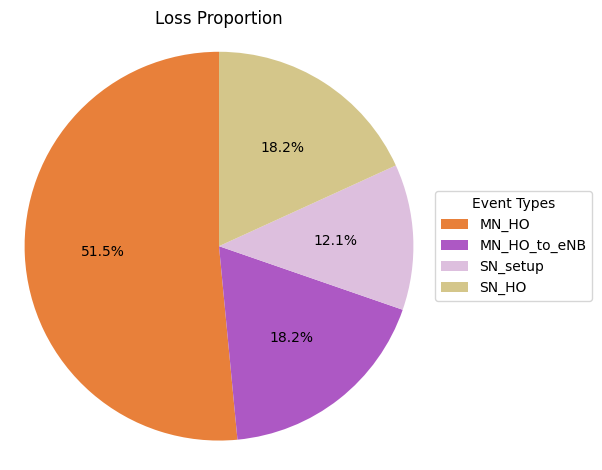

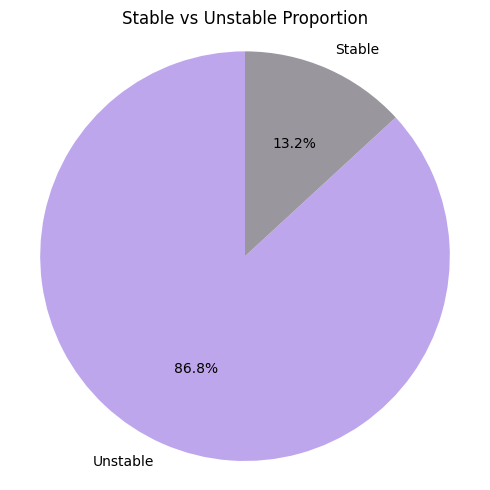

In [127]:
LossProportion(all_pkl_sum_ul, "ul")
LossProportion(all_real_pkl_sum_ul, "ul_adjusted")

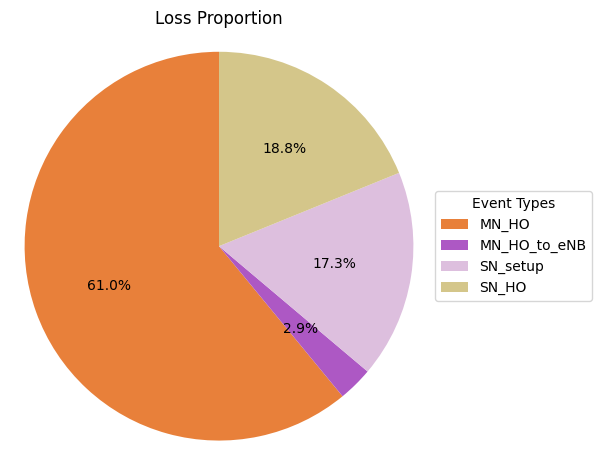

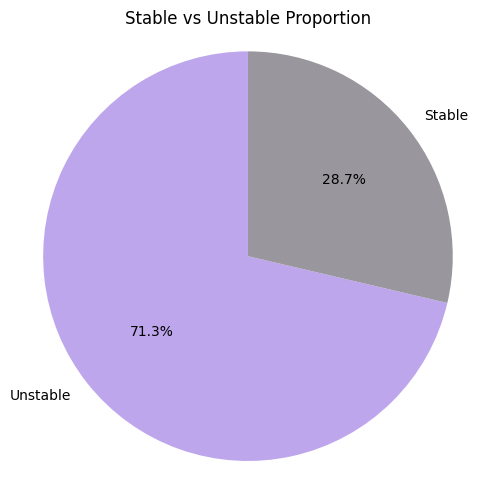

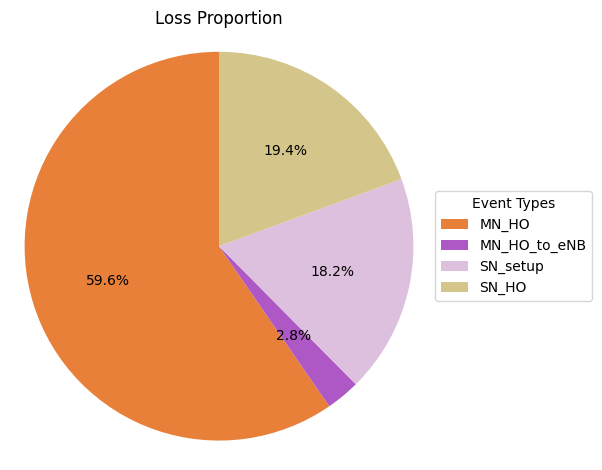

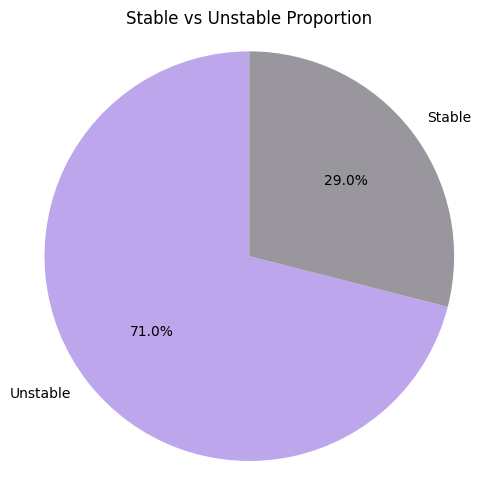

In [128]:
LossProportion(all_pkl_sum_dl, "dl")
LossProportion(all_real_pkl_sum_dl, "dl_adjusted")

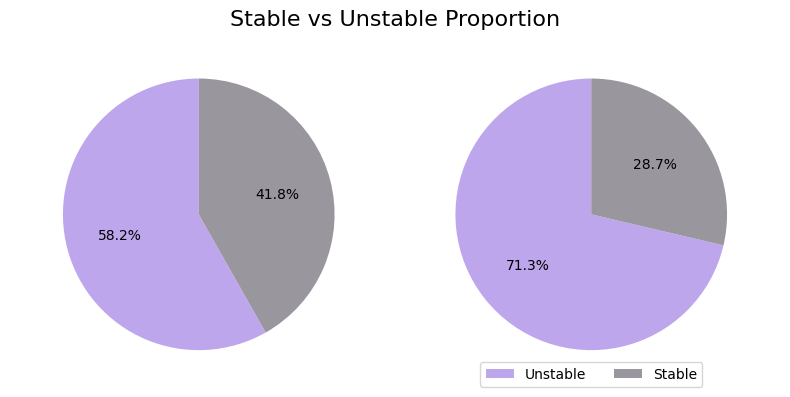

In [129]:
UlDlStableProportion(all_pkl_sum_ul, all_pkl_sum_dl)

In [130]:
def LossExclProportion(all_loss_df, all_real_loss_df, all_excl_df, ul_dl):
    # Calculate lengths of all_real_loss_df and all_excl_df
    real_loss_length = len(all_real_loss_df)
    excl_length = len(all_excl_df)

    # Calculate proportions
    total_length = len(all_loss_df)
    real_loss_proportion = real_loss_length / total_length
    excl_proportion = excl_length / total_length

    # Plot the pie chart
    sizes = [real_loss_proportion, excl_proportion]
    colors = ['lightcoral', 'lightskyblue']
    explode = (0.1, 0)  # explode the 1st slice (Real Loss)
    plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Proportion of Real Loss & Threshhold Exceeded')
    plt.legend(['Real Loss', 'Threshhold Exceeded'], loc='upper center', bbox_to_anchor=(0.5, 0), shadow=True, ncol=2)
    plt.savefig(f"{figure_path}/real_pkl_proportion_{ul_dl}.png")
    plt.show()

def TimeReorderExclProportion(all_excl_df, all_time_excl_df, all_reorder_excl_df,  ul_dl):
    total_excl_length = len(all_excl_df)
    time_excl_length = len(all_time_excl_df)
    reorder_excl_length = len(all_reorder_excl_df)
    time_excl_proportion = time_excl_length / total_excl_length
    reorder_excl_proportion = reorder_excl_length / total_excl_length

    sizes = [time_excl_proportion, reorder_excl_proportion]
    colors = ['#e08dca', '#e08d9b']
    explode = (0.1, 0)  # explode the 1st slice (Real Loss)
    plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Proportion of Threshhold Exceeded')
    plt.legend(['Time Threshold', 'Reorder Threshhold'], loc='upper center', bbox_to_anchor=(0.5, 0), shadow=True, ncol=2)
    plt.savefig(f"{figure_path}/threshold_excl_proportion_{ul_dl}.png")
    plt.show()


In [131]:
all_ul_time_df = all_ul_loss_df[all_ul_loss_df['trigger']=="time_threshold"]
all_ul_reorder_df = all_ul_loss_df[all_ul_loss_df['trigger']=="reordering_threshold"]
all_ul_time_excl_df = all_ul_excl_df[all_ul_excl_df['trigger']=="time_threshold"]
all_ul_reorder_excl_df = all_ul_excl_df[all_ul_excl_df['trigger']=="reordering_threshold"]
all_dl_time_df = all_dl_loss_df[all_dl_loss_df['trigger']=="time_threshold"]
all_dl_reorder_df = all_dl_loss_df[all_dl_loss_df['trigger']=="reordering_threshold"]
all_dl_time_excl_df = all_dl_excl_df[all_dl_excl_df['trigger']=="time_threshold"]
all_dl_reorder_excl_df = all_dl_excl_df[all_dl_excl_df['trigger']=="reordering_threshold"]

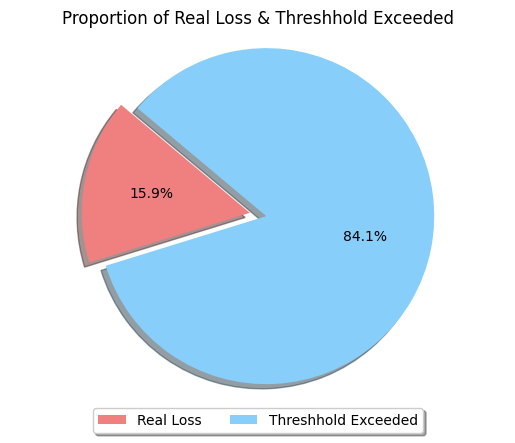

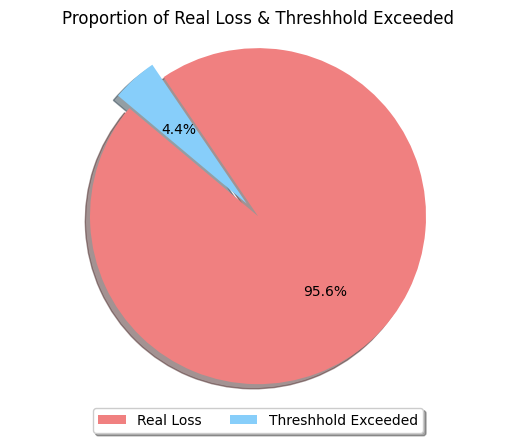

In [132]:
LossExclProportion(all_ul_loss_df, all_ul_real_loss_df, all_ul_excl_df, "ul")
LossExclProportion(all_dl_loss_df, all_dl_real_loss_df, all_dl_excl_df, "dl")

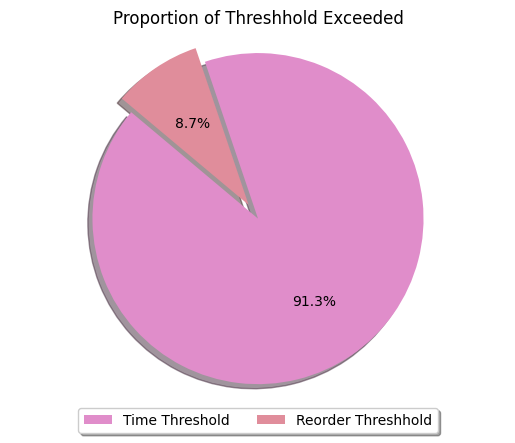

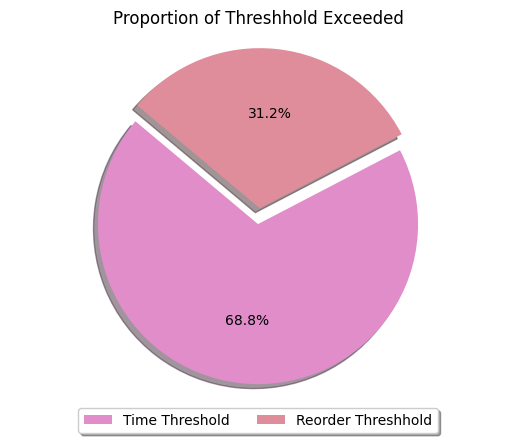

In [133]:
TimeReorderExclProportion(all_ul_excl_df, all_ul_time_excl_df, all_ul_reorder_excl_df, "ul")
TimeReorderExclProportion(all_dl_excl_df, all_dl_time_excl_df, all_dl_reorder_excl_df, "dl")

In [134]:
def ThresholdProportion(all_loss_df, all_time_df, all_reorder_df, all_time_excl_df, all_reorder_excl_df, ul_dl):
    # Calculate proportions for all_loss_df
    total_length = len(all_loss_df)
    time_proportion = len(all_time_df) * 100 / total_length
    reorder_proportion = len(all_reorder_df) * 100 / total_length

    # Calculate proportions for all_time_excl_df and all_reorder_excl_df
    time_excl_proportion = len(all_time_excl_df) * 100 / len(all_time_df)
    reorder_excl_proportion = len(all_reorder_excl_df) * 100 / len(all_reorder_df)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot bar chart for all_loss_df
    labels_all = ['Time Threshold', 'Reordering Threshold']
    proportions_all = [time_proportion, reorder_proportion]
    colors_all = ['lightblue', 'lightgreen']

    axes[0].bar(labels_all, proportions_all, color=colors_all)
    axes[0].set_title('Proportion of Thresholds')
    # axes[0].set_xlabel('Threshold Type')
    axes[0].set_ylabel('Proportion(%)')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].yaxis.set_major_locator(ticker.MultipleLocator(10))  # Set y-axis intervals to 10

    # Plot bar chart for all_excl_df
    labels_excl = ['Time Exceeded', 'Reordering Exceeded']
    proportions_excl = [time_excl_proportion, reorder_excl_proportion]
    colors_excl = ['lightcoral', 'lightsalmon']

    axes[1].bar(labels_excl, proportions_excl, color=colors_excl)
    axes[1].set_title('Proportion of Thresholds Exceeded')
    # axes[1].set_xlabel('Threshold Type')
    axes[1].set_ylabel('Proportion(%)')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].yaxis.set_major_locator(ticker.MultipleLocator(10))  # Set y-axis intervals to 10

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.savefig(f"{figure_path}/threshold_{ul_dl}.png")
    plt.show()

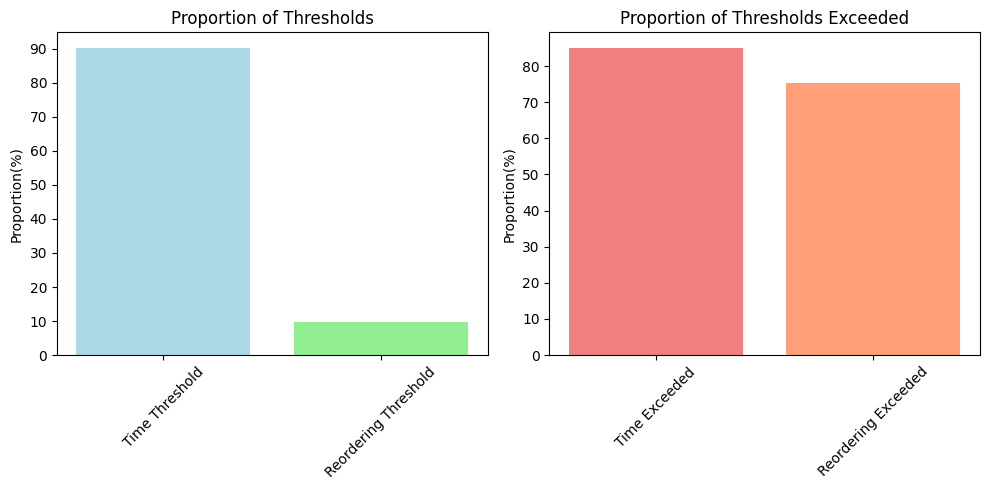

In [135]:
ThresholdProportion(all_ul_loss_df, all_ul_time_df, all_ul_reorder_df, all_ul_time_excl_df, all_ul_reorder_excl_df, "ul")

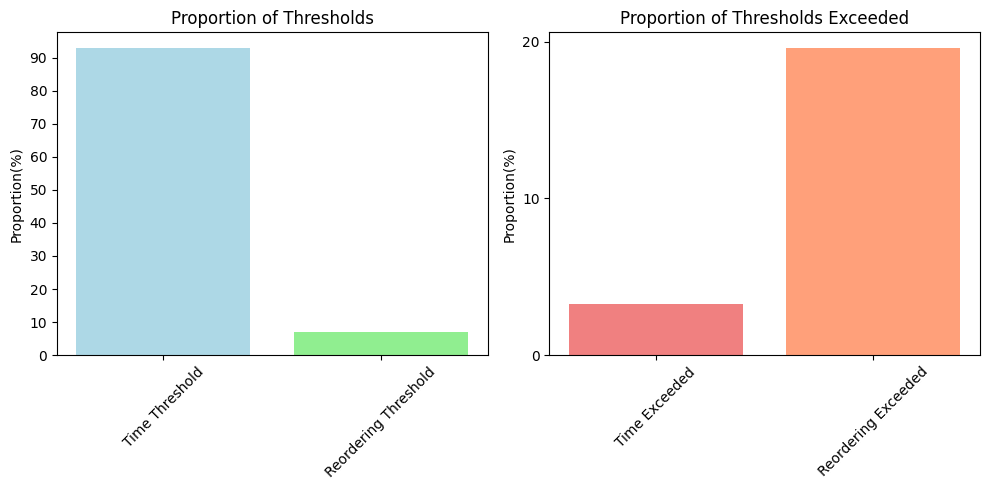

In [136]:
ThresholdProportion(all_dl_loss_df, all_dl_time_df, all_dl_reorder_df, all_dl_time_excl_df, all_dl_reorder_excl_df, "dl")

Calulate the occurrence of every event

In [137]:
def PlotHoFreq(all_ho_count):
    # Sort the data by values in descending order
    sorted_data = dict(sorted(all_ho_count.items(), key=lambda item: item[1], reverse=True))
    print(sorted_data)
    # Extract keys and values
    keys = list(sorted_data.keys())
    values = list(sorted_data.values())

    # Plot the data with colors
    plt.figure(figsize=(12, 6))
    plt.bar(keys, values, color=[colors_dict[key] for key in keys])
    plt.xlabel('Event Type')
    plt.ylabel('Frequency')
    plt.title('Frequency of Event Occurrence')
    plt.tight_layout()
    plt.savefig(f"{figure_path}/ho_frequency.png")
    plt.show()

# HO count and the average packet loss per event
def PlotHoPkl(all_ho_count, success_pkl_sum, failure_pkl_sum, ul_dl):
    # Sort the data by keys
    sorted_data = dict(sorted(all_ho_count.items(), key=lambda item: item[1], reverse=True))
    # Extract keys and values
    keys = list(sorted_data.keys())
    values = list(sorted_data.values())

    # plot the handover bar chart with colors
    fig, ax1 = plt.subplots(figsize=(12, 6))
    bars = ax1.bar(keys, values, color=[colors_dict[key] for key in keys])

    # Plot the line chart
    ax2 = ax1.twinx()
    x = list(range(len(keys)))
    # Cmbine success and failure ho
    pkl_sum = {**success_pkl_sum, **failure_pkl_sum}
    y = [pkl_sum[key] for key in keys]
    line = ax2.plot(x, y, marker='o', color='black', label='Frequency')

    # make 0 at the bottom
    ax1.set_ylim(bottom=0)
    ax2.set_ylim(bottom=0)

    # Set labels and titles
    ax1.set_xlabel('Event Type')
    ax1.set_ylabel('Handover Frequency', color='black')
    ax2.set_ylabel('Total Packet Loss', color='black')
    ax1.set_title('Frequency of Event Occurrence')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{figure_path}/event_frequency_{ul_dl}.png")
    plt.show()

# Packet loss per event & page loss rate
def PlotPklPlr(all_ho_count, success_pkl_sum, failure_pkl_sum, page_loss_rate, ul_dl):
    # Exclude keys and concat data
    exclude_keys = ['stable']
    success_pkl_sum_mod = {k: v for k, v in success_pkl_sum.items() if k not in exclude_keys}
    pkl_sum = {**success_pkl_sum_mod, **failure_pkl_sum}
   
    # Calculate pkl_per_event values
    pkl_per_event_values = {}
    for key in pkl_sum.keys():
        if all_ho_count[key] != 0:
            pkl_per_event_values[key] = (pkl_sum[key] / all_ho_count[key])
        else:
            pkl_per_event_values[key] = 0  # Assign 0 if denominator is zero
    # Sort the data by keys
    sorted_pkl_sum = dict(sorted(pkl_per_event_values.items(), key=lambda item: item[1], reverse=True))
    # Extract keys and values
    keys = list(sorted_pkl_sum.keys())
    

    # Plot the handover bar chart with colors
    fig, ax1 = plt.subplots(figsize=(12, 6))
    bars = ax1.bar(keys, list(sorted_pkl_sum.values()), color=[colors_dict[key] for key in keys])

    # Plot the line chart
    ax2 = ax1.twinx()
    x = list(range(len(keys)))
    y = [page_loss_rate[key] for key in keys]
    line = ax2.plot(x, y, marker='o', color='black', label='PLR')

    # Make 0 at the bottom
    ax1.set_ylim(bottom=0)
    ax2.set_ylim(bottom=0)

    # Set labels and titles
    ax1.set_xlabel('Event Type')
    ax1.set_ylabel('Packet Loss per Event', color='black')
    ax2.set_ylabel('Packet Loss Rate', color='black')
    ax1.set_title('Packet Loss and Packet Loss Rate')
    ax2.legend(loc='upper right')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{figure_path}/pkl_plr_{ul_dl}.png")
    plt.show()

def PlotHoPlr(all_ho_count, page_loss_rate, ul_dl):
    sorted_page_loss_rate = dict(sorted(page_loss_rate.items(), key=lambda item: item[1], reverse=True))
    sorted_event_types = list(sorted_page_loss_rate.keys())
    loss_rates = list(rate * 100 for rate in sorted_page_loss_rate.values())
    event_counts = [all_ho_count[event_type] for event_type in sorted_event_types]
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    # Plot bar chart for all_ho_count
    bars = ax1.bar(sorted_event_types, event_counts, color=[colors_dict[key] for key in sorted_event_types], label='Event Count')

    # Create secondary axis for line chart
    ax2 = ax1.twinx()

    # Plot line chart for page_loss_rate
    line = ax2.plot(sorted_event_types, loss_rates, color='black', marker='o', label='Packet Loss Rate')
    
    # Make 0 at the bottom
    ax1.set_ylim(bottom=0)
    ax2.set_ylim(bottom=0)
    # Set labels and title
    ax1.set_xlabel('Event Type')
    ax1.set_ylabel('Event Count', color='black')
    ax2.set_ylabel('Packet Loss Rate(%)', color='black')
    plt.title('Event Count and Packet Loss Rate')
    plt.xticks(rotation=45)
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"{figure_path}/ho_plr_{ul_dl}.png")
    plt.show()

In [138]:
## Calulate the occurrence of every event
all_ho_count = {key: len(value) for key, value in all_ho_dict.items()}

# Print the lengths dictionary
print(all_ho_count)

{'Conn_Rel': 3, 'Conn_Req': 5, 'LTE_HO': 1, 'MN_HO': 121, 'MN_HO_to_eNB': 11, 'SN_setup': 24, 'SN_Rel': 0, 'SN_HO': 123, 'RLF_II': 9, 'RLF_III': 1, 'SCG_RLF': 0}


{'SN_HO': 123, 'MN_HO': 121, 'SN_setup': 24, 'MN_HO_to_eNB': 11, 'RLF_II': 9, 'Conn_Req': 5, 'Conn_Rel': 3, 'LTE_HO': 1, 'RLF_III': 1, 'SN_Rel': 0, 'SCG_RLF': 0}


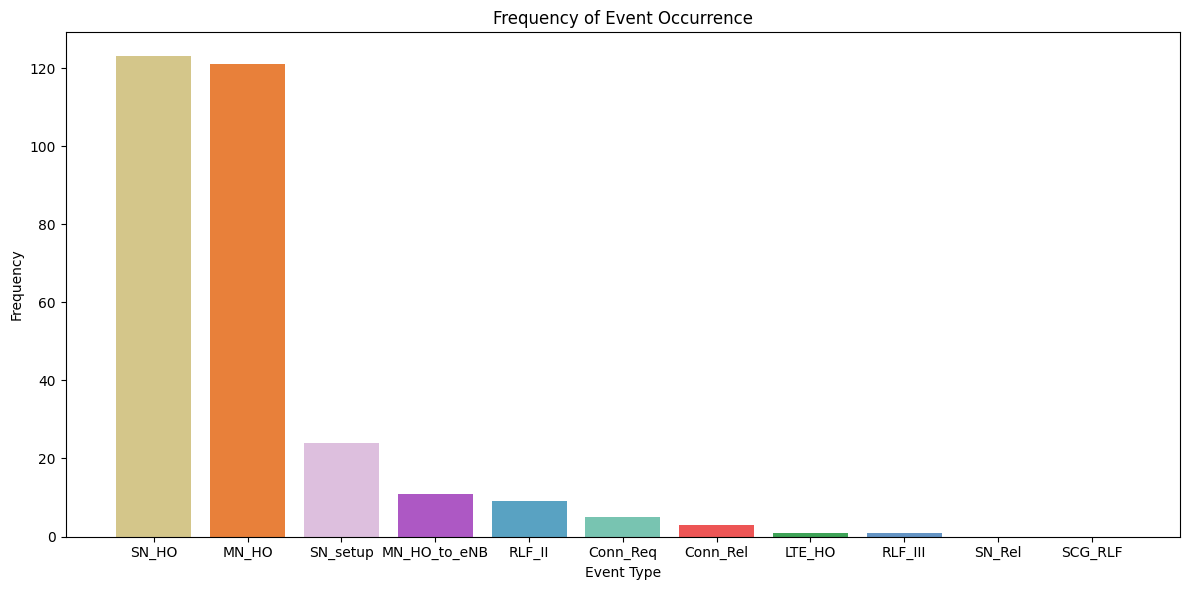

In [139]:
PlotHoFreq(all_ho_count)

In [140]:
# PlotHoPkl(all_ho_count, success_pkl_sum_ul, failure_pkl_sum_ul, "ul")

In [141]:
# PlotHoPkl(all_ho_count, success_pkl_sum_dl, failure_pkl_sum_dl, "dl")

In [142]:
# PlotPklPlr(all_ho_count, success_pkl_sum_ul, failure_pkl_sum_ul, page_loss_rate_ul, "ul")

In [143]:
# PlotPklPlr(all_ho_count, success_pkl_sum_dl, failure_pkl_sum_dl, page_loss_rate_dl, "dl")

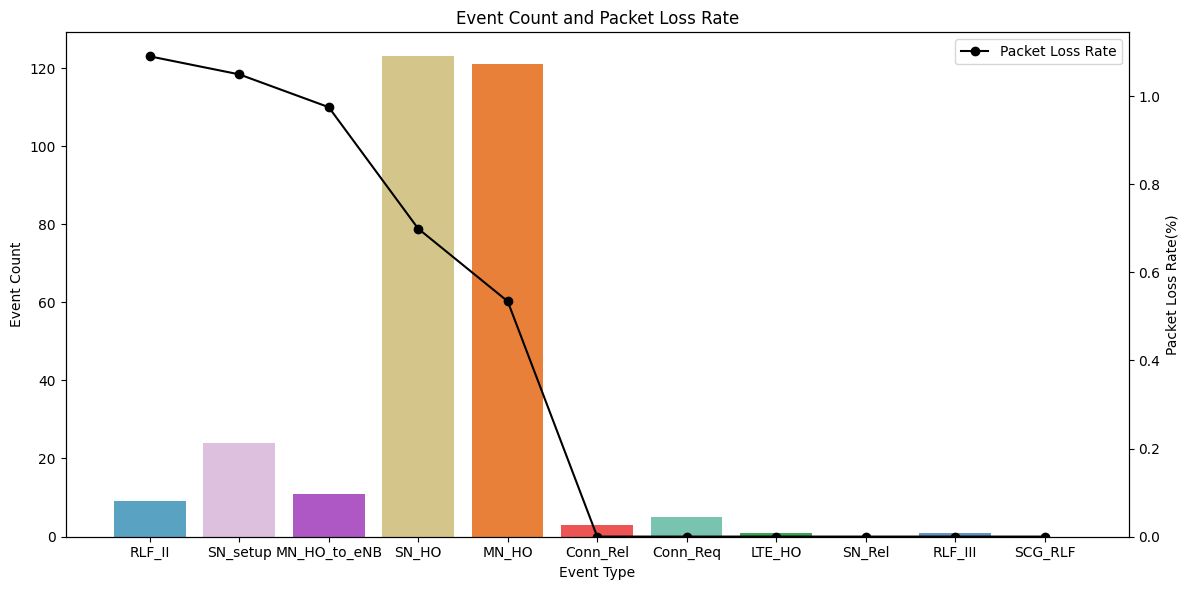

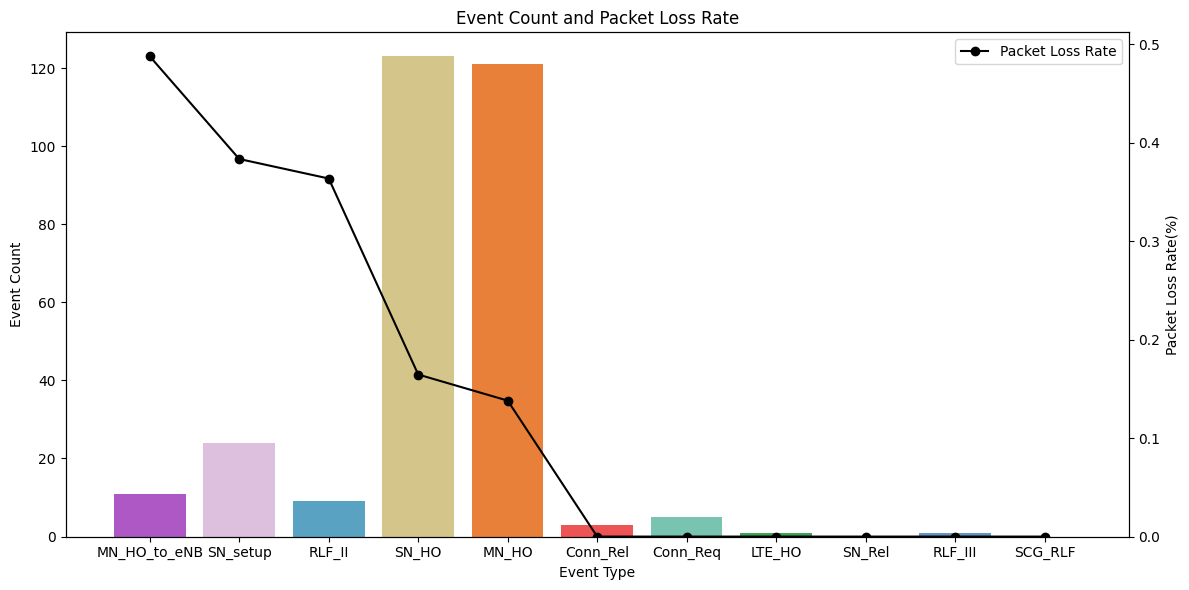

In [144]:
PlotHoPlr(all_ho_count, pk_loss_rate_ul, "ul")
PlotHoPlr(all_ho_count, real_pk_loss_rate_ul, "ul_adjusted")

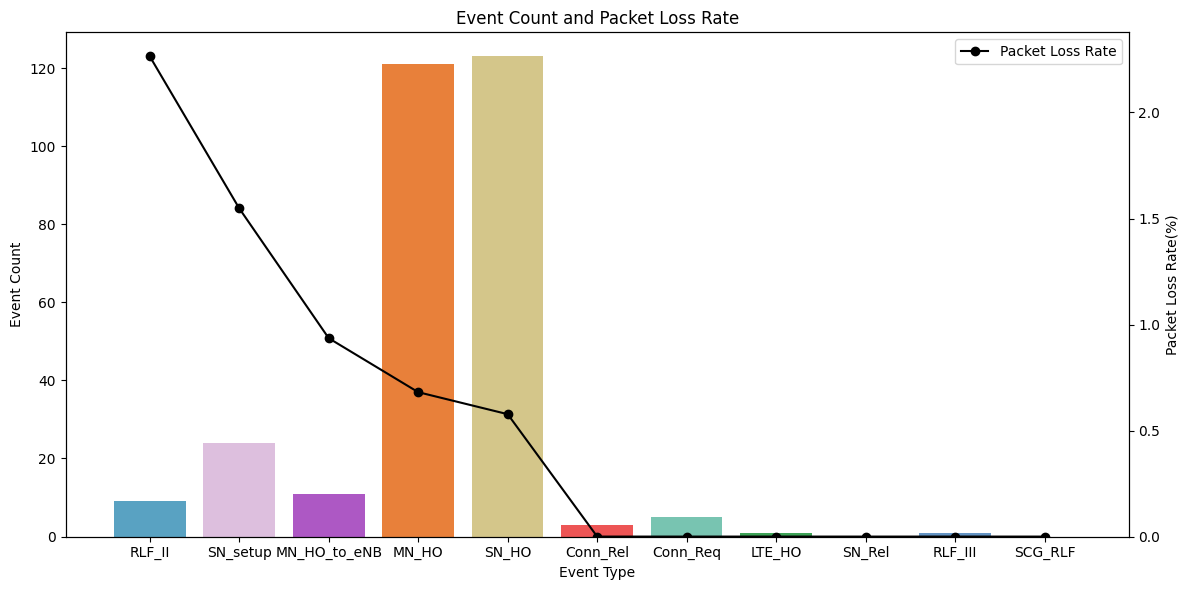

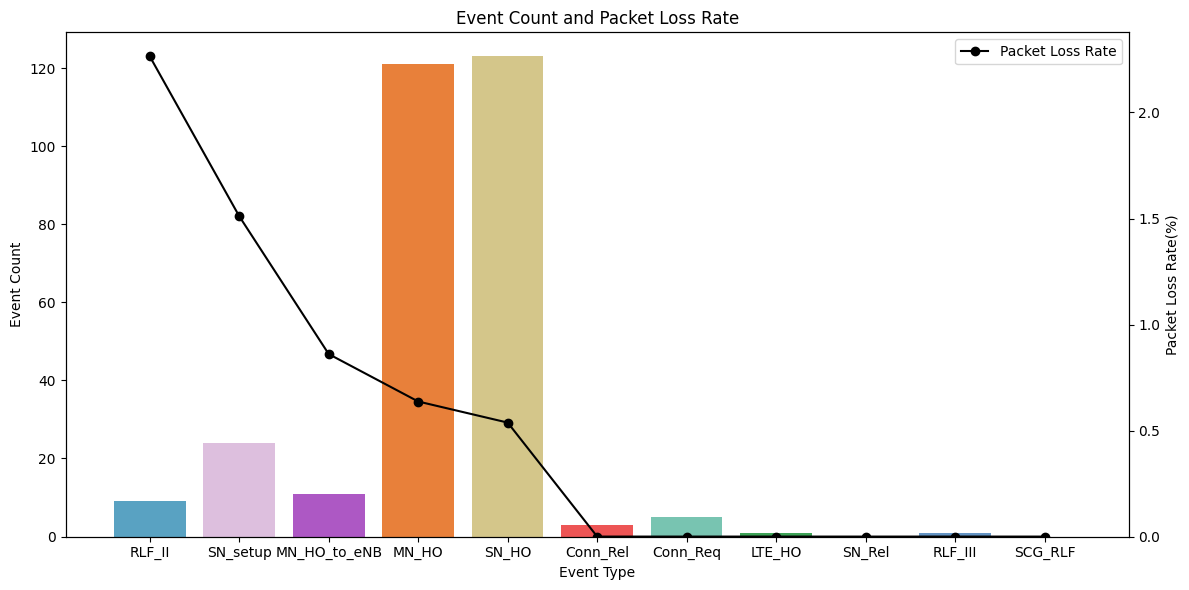

In [145]:
PlotHoPlr(all_ho_count, pk_loss_rate_dl, "dl")
PlotHoPlr(all_ho_count, real_pk_loss_rate_dl, "dl_adjusted")

## Statistics

PTO count